In [12]:
%%time

import os

from adlfs import AzureBlobFileSystem
from common.functions.functions import Functions

import pandas
from tqdm import tqdm

from common.storage.azure_file_storage import AzureFileStorageAdapter

tqdm.pandas(desc="Progress")
file_system: AzureBlobFileSystem = AzureFileStorageAdapter('data').get_file_storage()

functions: Functions = Functions()

CPU times: total: 0 ns
Wall time: 9 ms


In [13]:
df: pandas.DataFrame = pandas.read_parquet('data/parquet/thumbnail_curation.parquet', engine='pyarrow',
										   filesystem=file_system)

sexy = df.where(
	(df['model'] == 'SexyDiffusion') |
	(df['model'] == 'SWFPetite') |
	(df['model'] == 'RedHeadDiffusion') |
	(df['model'] == 'NextDoorGirlsDiffusion') |
	(df['model'] == 'SexyAsianDiffusion') |
	(df['model'] == 'PrettyGirlDiffusion'))

sexy = sexy.where((df['thumbnail_accept'] == True))

sexy.dropna(inplace=True)
sexy.reset_index(inplace=True, drop=True)

display(sexy)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,...,exists,curated,accept,tags,azure_caption,thumbnail_path,thumbnail_exists,thumbnail_curated,thumbnail_accept,additional_captions
0,1013bdt,AmIhotAF,RaulDea9286,36F - ITALIAN,arafed image of a woman in a bikini top,7c0d158cba8654ef1c635cbc5471d597,/r/AmIhotAF/comments/1013bdt/36f_italian/,https://i.redd.it/bg0wwdlt5k9a1.jpg,1013bdt.jpg,data/image/1013bdt.jpg,...,True,True,True,"[person, human face, clothing, lady, smile, ch...",a woman taking a selfie,data/image/thumbnail/1013bdt.jpg,True,True,True,"[a woman taking a selfie, a close up of an eye..."
1,105mekt,AmIhotAF,lindaniz,interesting in good forward relationship (f24),a close up of a woman with red hair and a whit...,ba4a0962cca2266a741e1e1700589c04,/r/AmIhotAF/comments/105mekt/interesting_in_go...,https://i.redd.it/4avjshsz8naa1.jpg,105mekt.jpg,data/image/105mekt.jpg,...,True,True,True,"[person, human face, skin, eyelash, eyebrow, b...",a woman taking a selfie,data/image/thumbnail/105mekt.jpg,True,True,True,"[a close up of a person's eye, a woman taking ..."
2,105qvgl,AmIhotAF,CaitVLove11,Laughing is my favorite 😆,a woman in a blue tank top and shorts is smili...,27bfe82c37314a0bcf02ab72eaf3a9e5,/r/AmIhotAF/comments/105qvgl/laughing_is_my_fa...,https://i.redd.it/2pulzr0lxmaa1.jpg,105qvgl.jpg,data/image/105qvgl.jpg,...,True,True,True,"[clothing, person, human face, smile, shoulder...",a woman smiling at camera,data/image/thumbnail/105qvgl.jpg,True,True,True,"[a woman smiling at camera, a woman with long ..."
3,105rpcj,AmIhotAF,Flashy-Desk1858,[f22] What do you think when you see me?,a woman in a blue bikini top and a blue bra top,329eb42b8267fa1cc2980da8e48bcef1,/r/AmIhotAF/comments/105rpcj/f22_what_do_you_t...,https://i.redd.it/rz68pf934naa1.jpg,105rpcj.jpg,data/image/105rpcj.jpg,...,True,True,True,"[person, human face, indoor, woman, chest, sho...",a woman taking a selfie,data/image/thumbnail/105rpcj.jpg,True,True,True,"[a woman taking a selfie, close up of a person..."
4,105styc,AmIhotAF,Gizzygirl127,Low key… still bangable?,smiling woman sitting on couch with remote con...,6d555943be4fbc21ff92417c6f582298,/r/AmIhotAF/comments/105styc/low_key_still_ban...,https://i.redd.it/aiaxxoz9uoaa1.jpg,105styc.jpg,data/image/105styc.jpg,...,True,True,True,"[person, human face, smile, clothing, woman, i...",a woman taking a selfie,data/image/thumbnail/105styc.jpg,True,True,True,"[a woman smiling at the camera, close-up of a ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3376,13ns65m,gentlemanboners,Far-Confection-1101,Morena Baccarin,a close up of a woman in a white dress posing ...,d6bac255b188bf29f142876d263b79bc,/r/gentlemanboners/comments/13ns65m/morena_bac...,https://i.redd.it/3z3mtjeh281b1.jpg,13ns65m.jpg,data/image/13ns65m.jpg,...,True,True,True,[],a woman in a white dress,data/image/thumbnail/13ns65m.jpg,True,True,True,"[a woman in a white dress, a woman smiling at ..."
3377,13nvtqd,gentlemanboners,Kvikkleire,Jennifer Lawrence,araffed woman in red dress posing for a pictur...,771c25ff92549e5447c7eb49a820bfc0,/r/gentlemanboners/comments/13nvtqd/jennifer_l...,https://i.redd.it/r06vv4syx61b1.jpg,13nvtqd.jpg,data/image/13nvtqd.jpg,...,True,True,True,[],a woman in a red dress,data/image/thumbnail/13nvtqd.jpg,True,True,True,"[a woman in a red dress, a woman with blonde h..."
3378,13nw4ss,gentlemanboners,Kvikkleire,Natalie Portman,a woman in a red dress and red coat posing for...,85453a20bb721d013e88b37a005df958,/r/gentlemanboners/comments/13nw4ss/natalie_po...,https://i.redd.it/0jb5tssc071b1.jpg,13nw4ss.jpg,data/image/13nw4ss.jpg,...,True,True,True,[],a woman in a red dress,data/image/thumbnail/13nw4ss.jpg,True,True,True,"[a woman in a red dress, a woman wearing a red..."
3379,13nwtx1,gentlemanboners,kape_pandesal,Ysabel Ortega,araffe woman in a blue dress posing for a picture,09d5b6d47007707d728928008111812e,/r/gentlemanboners/comments/13nwtx1/ysabel_ort

<Axes: title={'center': 'Models with most images'}, xlabel='model'>

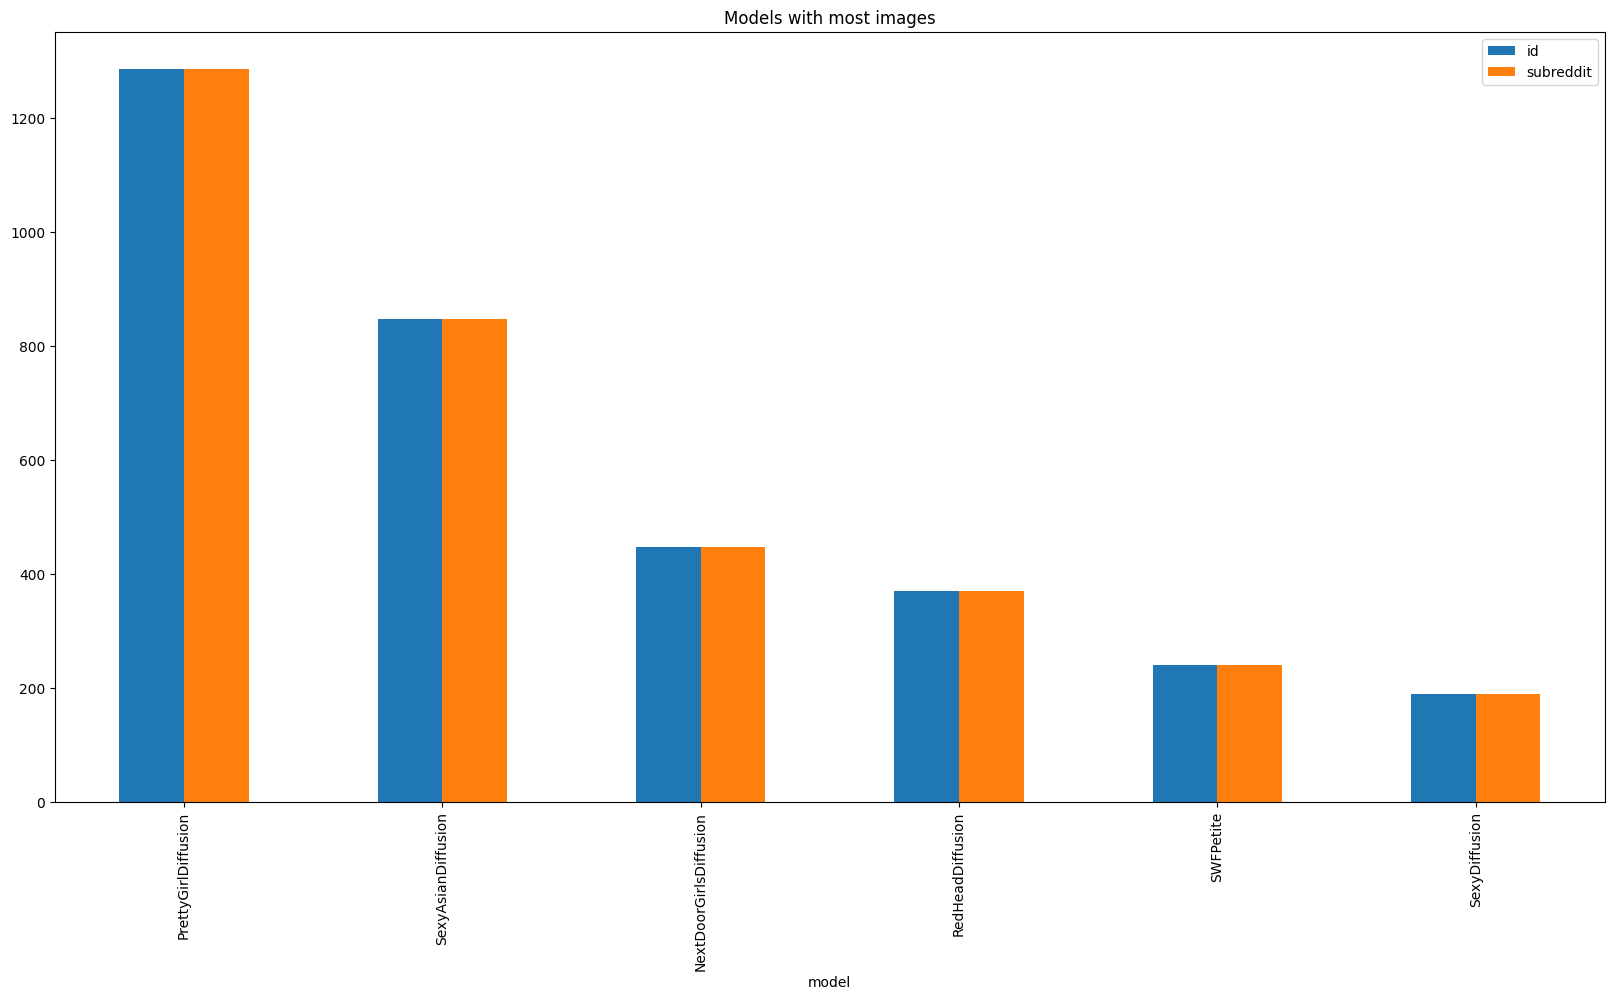

In [14]:
group = sexy[["id", "model", "subreddit"]].groupby(["model"]).count().sort_values(by="id", ascending=False)

plot_1 = group.plot.bar(figsize=(20, 10), title="Models with most images", legend=True)

display(plot_1)

In [34]:
import random
files = file_system.ls('data/training/sexy', recursive=True)
for item in tqdm(files, total=len(files), desc="Deleting files"):
	file_system.delete(item)

lines = []
files = file_system.ls('data/training/sexy')
files = [file.replace('data/training/sexy/', '') for file in files]
records = sexy.to_dict(orient='records')
random.shuffle(records)
samples = random.sample(records, 100)
for primary_image_index, primary_image_record in tqdm(enumerate(samples), total=len(samples), desc="Processing images"):
	try:
		image_name = primary_image_record['image_name']
		if image_name is None or image_name == "":
			print("Entry is null")
			continue

		captions = primary_image_record['additional_captions'].tolist()
		captions.append(primary_image_record['azure_caption'])
		captions.append(primary_image_record['caption'])
		captions.append(primary_image_record['title'])
		captions = [caption.replace("person", "woman") for caption in list(set(captions))]
		random.shuffle(captions)

		if primary_image_record['model'] == "SexyAsianDiffusion":
			captions = [caption.replace("a woman", "an asian woman") for caption in captions]
		if primary_image_record['model'] == "RedHeadDiffusion":
			captions = [caption.replace("woman", "redhead woman") for caption in captions]

		image_to_copy = f"{str(primary_image_index)}_{image_name}"

		for secondary_image_caption_index, sample_caption in tqdm(enumerate(captions), total=len(captions), desc="Processing captions"):
			secondary_image_name_to_copy = f"{str(primary_image_index)}_{str(secondary_image_caption_index)}_{image_name}"
			data_row = {'file_name': secondary_image_name_to_copy, 'text': sample_caption}
			file_system.copy(f'data/image/thumbnail/{image_name}', f'data/training/sexy/{image_to_copy}', on_error='raise')
			lines.append(data_row)

			if primary_image_index % 10 == 0:
				continue
			else:
				data_row = {'file_name': secondary_image_name_to_copy, 'text': random.choice(captions)}
				file_system.copy(f'data/image/{image_name}', f'data/training/sexy/big_{secondary_image_name_to_copy}', on_error='raise')
				lines.append(data_row)

	except Exception as e:
		print(e)

		continue

df = pandas.DataFrame(data=lines)
display(df)


Processing images: 100%|██████████| 100/100 [03:22<00:00,  2.03s/it]


,file_name,text
0,0_0_106dg98.jpg,a woman in a garment on a swing
1,0_1_106dg98.jpg,Happy day (iktr)
2,0_2_106dg98.jpg,a woman smiling with long hair
3,0_3_106dg98.jpg,a close up of a woman's garment
4,0_4_106dg98.jpg,arafed woman in a bikinisuit sitting on a swin...
...,...,...
1172,99_2_13dwbm5.jpg,a woman wearing a black dress
1173,99_3_13dwbm5.jpg,two women in dresses standing next to each oth...
1174,99_3_13dwbm5.jpg,two women in dresses standing next to each oth...
1175,99_4_13dwbm5.jpg,two women posing for a picture


In [35]:
display("== Adding Caption Data ==")
df.to_json('metadata.jsonl', orient='records', lines=True)
file_system.upload('metadata.jsonl', 'data/training/sexy', overwrite=True)

'== Adding Caption Data =='

[None]

In [18]:
gpt_lines = []
for record in tqdm(sexy.to_dict(orient='records'), total=len(sexy)):
	name = record['model']
	prompt = record['title']
	captions = record['additional_captions'].tolist()
	captions.append(record['azure_caption'])
	captions.append(record['caption'])
	captions.append(record['title'])
	captions = [caption.replace("person", "woman") for caption in list(set(captions))]
	for caption in captions:
		if record['model'] == "SexyAsianDiffusion":
			caption = caption.replace("a woman", "an asian woman")
		if record['model'] == "RedHeadDiffusion":
			caption = caption.replace("woman", "redhead woman")
		line = f"<|startoftext|><|model|>{name}<|prompt|>{prompt}<|text|>{caption}<|endoftext|>" + "\n"
		gpt_lines.append(line)

with open("training.txt", "wb") as f:
	for line in gpt_lines:
		f.write(line.encode("utf-8"))

100%|██████████| 3381/3381 [00:00<00:00, 19101.64it/s]


In [19]:
with open('training.txt', 'rb') as f:
	text = f.read()
	display(text)

b'<|startoftext|><|model|>SexyDiffusion<|prompt|>36F - ITALIAN<|text|>a woman taking a selfie<|endoftext|>\n<|startoftext|><|model|>SexyDiffusion<|prompt|>36F - ITALIAN<|text|>a close up of a nose<|endoftext|>\n<|startoftext|><|model|>SexyDiffusion<|prompt|>36F - ITALIAN<|text|>a close up of an eye<|endoftext|>\n<|startoftext|><|model|>SexyDiffusion<|prompt|>36F - ITALIAN<|text|>36F - ITALIAN<|endoftext|>\n<|startoftext|><|model|>SexyDiffusion<|prompt|>36F - ITALIAN<|text|>arafed image of a woman in a bikini top<|endoftext|>\n<|startoftext|><|model|>SexyDiffusion<|prompt|>interesting in good forward relationship (f24)<|text|>close up of a woman\'s lips<|endoftext|>\n<|startoftext|><|model|>SexyDiffusion<|prompt|>interesting in good forward relationship (f24)<|text|>interesting in good forward relationship (f24)<|endoftext|>\n<|startoftext|><|model|>SexyDiffusion<|prompt|>interesting in good forward relationship (f24)<|text|>a woman taking a selfie<|endoftext|>\n<|startoftext|><|model|>

In [20]:
file_system.upload('training.txt', 'data/training/training.txt', overwrite=True)

[None]

In [21]:
file_system.ls('data/training/training.txt')

['data/training/training.txt']